<a href="https://colab.research.google.com/github/devhemza/BERTweet_sentiment_analysis/blob/main/Bert_base_vs_BERTweet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
RANDOM_SEED = 11

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Initialisation

In [ ]:
!nvidia-smi

Sat Feb  6 05:44:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def writeResultsInFile(accuracy, f1_score, random_seed):
    f = open("log_bert", "a")
    f.write(f'Random seed : {random_seed}, accuracy : {accuracy:.4f}, f1-score : {f1_score:.4f}\n')
    f.close()


In [ ]:
!cd "/content/drive/MyDrive/TER BERTTweet"

In [ ]:
CUDA_LAUNCH_BLOCKING="1"

In [ ]:
"""
!git clone https://github.com/huggingface/transformers.git
%cd transformers/
!pip3 install --upgrade .
"""

'\n!git clone https://github.com/huggingface/transformers.git\n%cd transformers/\n!pip3 install --upgrade .\n'

In [ ]:
!pip3 install emoji
!pip install transformers sentencepiece

     |████████████████████████████████| 133kB 9.1MB/s 
     |████████████████████████████████| 1.8MB 8.0MB/s 
     |████████████████████████████████| 1.2MB 36.0MB/s 
     |████████████████████████████████| 2.9MB 47.9MB/s 
     |████████████████████████████████| 890kB 54.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=13a7f584f760329b16c23559048f88e3f0c65343d22ad4fcfc6ae7fdee83a7f0
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
#imports hugging face 
from transformers import BertTokenizer, BertModel 

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
import transformers
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, recall_score, f1_score, accuracy_score, average_precision_score, precision_score
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline


np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class SATweetDataset(Dataset):

  def __init__(self, tweets, targets, tokenizer, max_len):
    self.tweets = tweets
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.tweets)
  
  def __getitem__(self, item):
    tweet = str(self.tweets[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens=True,
      max_length=self.max_len,
      truncation= True,
      return_token_type_ids=False,
      padding = 'max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'tweet_text': tweet,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):

    ds = SATweetDataset(
        tweets=df.body.to_numpy(),
        targets=df.target.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )


In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = bert_model.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = pooled_output
    return self.out(output)

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer,  device, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  tweets_content = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      
      _, preds = torch.max(outputs, dim=1)
      
      probs = nn.functional.softmax(outputs, dim=1)

      tweets_content.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return tweets_content, predictions, prediction_probs, real_values

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

In [ ]:
def avg_rec(y_test, y_pred):
    rec_n, rec_u, rec_p = recall_score(y_test, y_pred, average=None)
    return (1/3) * (rec_n+ rec_u+ rec_p)


In [ ]:
def f1_np(y_test, y_pred):
    f1_n, _,f1_p = f1_score(y_test, y_pred, average=None)
    return 0.5*(f1_n+f1_p)

## SemEval-2018Task3A

In [ ]:
%ls

drive/  sample_data/


In [ ]:
%cd '/content/drive/MyDrive/TER BERTTweet/SemEval-2018Task3A/datasets'

/content/drive/.shortcut-targets-by-id/17CE24Rj2KkFXfKV0IKGKdgQ9DW8PLJeH/TER BERTTweet/SemEval-2018Task3A/datasets


In [ ]:
df_semEval18_train = pd.read_csv('train/SemEval2018-T3-train-taskA_emoji.txt', skiprows=[0], names = ['id', 'target', 'body'], sep = "\t")
df_semEval18_test = pd.read_csv('goldtest_TaskA/SemEval2018-T3_gold_test_taskA_emoji.txt', skiprows=[0], names = ['id', 'target', 'body'], sep = "\t")
df_semEval18_train

,id,target,body
0,1,1,Sweet United Nations video. Just in time for C...
1,2,1,@mrdahl87 We are rumored to have talked to Erv...
2,3,1,Hey there! Nice to see you Minnesota/ND Winter...
3,4,0,3 episodes left I'm dying over here
4,5,1,I can't breathe! was chosen as the most notabl...
...,...,...,...
3812,3830,0,@banditelli regarding what the PSU president does
3813,3831,0,@banditelli But still bothers me that I see no...
3814,3832,0,well now that i've listened to all of into the...
3815,3833,0,Hummingbirds #Are #Experts #at #Hovering #Aft...


In [ ]:
df_semEval18_train['target'] = df_semEval18_train['target'].astype(int)

In [ ]:
df_semEval18_test['target'] = df_semEval18_test['target'].astype(int)

In [ ]:
token_lens = []
for txt in df_semEval18_train.body:
  tokens = tokenizer.encode(txt, max_length=128)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


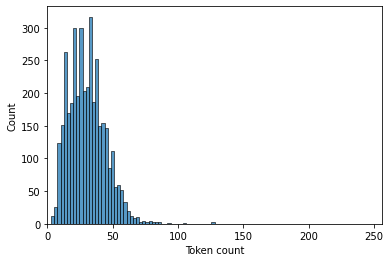

In [ ]:
sns.histplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = max(token_lens)
BATCH_SIZE = 32

In [ ]:
MAX_LEN

128

In [ ]:

df_train, df_val = train_test_split(df_semEval18_train, test_size=0.1, random_state=RANDOM_SEED)
df_test = df_semEval18_test

In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
#test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
data = next(iter(val_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
n_classes = 2
class_names = ['ironic', 'non-ironic']

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 128])
torch.Size([32, 128])


In [ ]:
model = SentimentClassifier(n_classes)
model = model.to(device)

In [ ]:
EPOCHS = 30

optimizer = optim.AdamW(model.parameters(), lr=1e-5)
total_steps = len(train_data_loader) * EPOCHS
"""
scheduler = transformers.get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
"""
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0
early_stop = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), f'best_model_state_random_state_{RANDOM_SEED}.bin')
    best_accuracy = val_acc
    early_stop = 0
  else:
      early_stop = early_stop + 1
      if early_stop == 5:
        break

Epoch 1/30
----------
Train loss 0.6504147872328758 accuracy 0.6189228529839884
Val   loss 0.6203309893608093 accuracy 0.6361256544502618

Epoch 2/30
----------
Train loss 0.5551074202413913 accuracy 0.7202328966521107
Val   loss 0.5712614754835764 accuracy 0.6963350785340314

Epoch 3/30
----------
Train loss 0.4438574960524285 accuracy 0.8034934497816595
Val   loss 0.619319828848044 accuracy 0.6832460732984293

Epoch 4/30
----------
Train loss 0.322403358226573 accuracy 0.8721979621542941
Val   loss 0.6952607010801634 accuracy 0.6727748691099477

Epoch 5/30
----------
Train loss 0.2241392945870757 accuracy 0.9269286754002912
Val   loss 0.8247049103180567 accuracy 0.675392670157068

Epoch 6/30
----------
Train loss 0.19698840026157322 accuracy 0.9356622998544397
Val   loss 0.8352726946274439 accuracy 0.6963350785340314

Epoch 7/30
----------
Train loss 0.13466206553426605 accuracy 0.9580786026200874
Val   loss 1.089712142944336 accuracy 0.6518324607329843

CPU times: user 5min 12s, sys

In [ ]:
model.load_state_dict(torch.load(f'best_model_state_random_state_{RANDOM_SEED}.bin'))

<All keys matched successfully>

In [ ]:
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.6390306122448979

In [ ]:
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      ironic       0.71      0.67      0.69       473
  non-ironic       0.54      0.59      0.56       311

    accuracy                           0.64       784
   macro avg       0.63      0.63      0.63       784
weighted avg       0.64      0.64      0.64       784



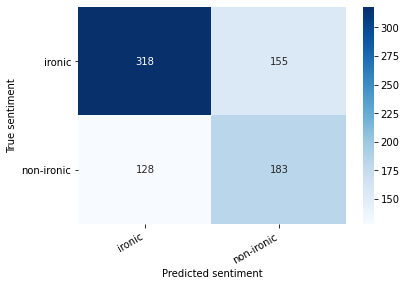

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
accuracy_score(y_test, y_pred)

0.639030612244898

In [ ]:
_,f1_p = f1_score(y_test, y_pred, average=None)

In [ ]:
print(f1_p)

0.5639445300462249


In [ ]:
writeResultsInFile(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted'), random_seed=RANDOM_SEED)

# SemEval 2019 TASK 5

In [ ]:
%cd '/content/drive/MyDrive/TER BERTTweet/SemEval2019Task5/datasets'

/content/drive/.shortcut-targets-by-id/17CE24Rj2KkFXfKV0IKGKdgQ9DW8PLJeH/TER BERTTweet/SemEval2019Task5/datasets


In [ ]:
!ls

best_model_state.bin	  hateval2019_es_train.csv
hateval2019_en_dev.csv	  log
hateval2019_en_test.csv   log_bert
hateval2019_en_train.csv  log_roberta
hateval2019_es_dev.csv	  Roberta_best_model_state.bin
hateval2019_es_test.csv


In [ ]:
df_semEval19_train = pd.read_csv('hateval2019_en_train.csv', sep = ",")
#df_semEval19_train_val = pd.read_csv('hateval2019_en_dev.csv', sep = "\t")
df_semEval19_valid = pd.read_csv('hateval2019_en_dev.csv',  sep = ",")
df_test_gold = pd.read_csv('hateval2019_en_test.csv', sep = ",")
#df_result = pd.read_csv('en_a.tsv', sep = "\t", names=["id", "target"])
#df_test_gold = pd.concat([df_semEval19_test, df_result.target], axis=1)

In [ ]:
df_test_gold

,id,text,HS,TR,AG
0,34243,"@local1025 @njdotcom @GovMurphy Oh, I could ha...",0,0,0
1,30593,Several of the wild fires in #california and #...,0,0,0
2,31427,@JudicialWatch My question is how do you reset...,0,0,0
3,31694,"#Europe, you've got a problem! We must hurry...",1,0,0
4,31865,This is outrageous! #StopIllegalImmigration #...,1,0,0
...,...,...,...,...,...
2995,31368,you can never take a L off a real bitch😩 im ho...,1,1,0
2996,30104,@Brian_202 likes to call me a cunt & a bitch b...,1,1,0
2997,31912,@kusha1a @Camio_the_wise @shoe0nhead 1. Never ...,1,1,0
2998,31000,If i see and know you a hoe why would i hit yo...,1,1,0


In [ ]:
df_train = df_semEval19_train.drop(columns=['TR', 'AG']).rename(columns = {"text" : "body", "HS" : "target"})
#df_train_val = df_semEval19_train_val.drop(columns=['TR', 'AG']).rename(columns = {"text" : "body", "HS" : "target"})
df_val = df_semEval19_valid.drop(columns=['TR', 'AG']).rename(columns = {"text" : "body", "HS" : "target"})
df_test = df_test_gold.drop(columns=['TR', 'AG']).rename(columns = {"text" : "body", "HS" : "target"})

In [ ]:
df_train

,id,body,target
0,201,"Hurray, saving us $$$ in so many ways @potus @...",1
1,202,Why would young fighting age men be the vast m...,1
2,203,@KamalaHarris Illegals Dump their Kids at the ...,1
3,204,NY Times: 'Nearly All White' States Pose 'an A...,0
4,205,Orban in Brussels: European leaders are ignori...,0
...,...,...,...
8995,9196,@mmdwriter @JRubinBlogger @BenSasse I am proud...,0
8996,9197,@CheriJacobus Hollywood is complicit in the ra...,0
8997,9198,@amaziah_filani What a fucking cunt I hate see...,1
8998,9199,Hysterical woman like @CoryBooker,0


In [ ]:
df_train_val = pd.concat([df_train, df_val], axis = 0)
df_train_val

,id,body,target
0,201,"Hurray, saving us $$$ in so many ways @potus @...",1
1,202,Why would young fighting age men be the vast m...,1
2,203,@KamalaHarris Illegals Dump their Kids at the ...,1
3,204,NY Times: 'Nearly All White' States Pose 'an A...,0
4,205,Orban in Brussels: European leaders are ignori...,0
...,...,...,...
995,19196,@SamEnvers you unfollowed me? Fuck you pussy,0
996,19197,@DanReynolds STFU BITCH! AND YOU GO MAKE SOME ...,1
997,19198,"@2beornotbeing Honey, as a fellow white chick,...",0
998,19199,I hate bitches who talk about niggaz with kids...,1


In [ ]:
df_train, df_val = train_test_split(df_train_val, test_size=0.1, random_state=RANDOM_SEED)

In [ ]:
token_lens = []
for txt in df_train.body:
  tokens = tokenizer.encode(txt, max_length=128)
  token_lens.append(len(tokens))

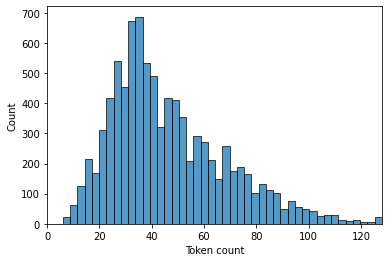

In [ ]:
sns.histplot(token_lens)
plt.xlim([0, 128]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = np.max(token_lens)
BATCH_SIZE = 32

In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
data = next(iter(val_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
n_classes = 2
class_names = ['hateful', 'non-hateful']

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 128])
torch.Size([32, 128])


In [ ]:
model = SentimentClassifier(n_classes)
model = model.to(device)

In [ ]:
EPOCHS = 30

optimizer = optim.AdamW(model.parameters(), lr=1e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = transformers.get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0
early_stop = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc
    early_stop = 0
  else:
      early_stop = early_stop + 1
      if early_stop == 5:
        break

Epoch 1/30
----------
Train loss 0.5228026124602514 accuracy 0.7377777777777779
Val   loss 0.46141532994806767 accuracy 0.798

Epoch 2/30
----------
Train loss 0.37750874908891974 accuracy 0.8271111111111111
Val   loss 0.4686213484965265 accuracy 0.807

Epoch 3/30
----------
Train loss 0.26688647701517276 accuracy 0.8893333333333334
Val   loss 0.5300403111614287 accuracy 0.798

Epoch 4/30
----------
Train loss 0.17642969445239567 accuracy 0.9328888888888889
Val   loss 0.5941238738596439 accuracy 0.795

Epoch 5/30
----------
Train loss 0.12183836738228904 accuracy 0.9543333333333334
Val   loss 0.6606376357376575 accuracy 0.808

Epoch 6/30
----------
Train loss 0.09338063421388361 accuracy 0.9684444444444444
Val   loss 0.6719344537705183 accuracy 0.803

Epoch 7/30
----------
Train loss 0.06816025398975463 accuracy 0.9771111111111112
Val   loss 0.7751701818779111 accuracy 0.81

Epoch 8/30
----------
Train loss 0.05012134655051805 accuracy 0.9851111111111112
Val   loss 0.8038819637149572 a

In [ ]:

model.load_state_dict(torch.load('best_model_state.bin'))

<All keys matched successfully>

In [ ]:
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.539

In [ ]:
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

     hateful       0.86      0.24      0.38      1740
 non-hateful       0.48      0.95      0.63      1260

    accuracy                           0.54      3000
   macro avg       0.67      0.60      0.51      3000
weighted avg       0.70      0.54      0.49      3000



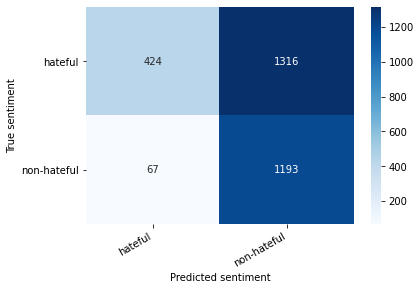

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
accuracy_score(y_test, y_pred)

0.539

In [ ]:
f1_score(y_test, y_pred)

0.6330591668877686

In [ ]:
writeResultsInFile(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted'), random_seed=RANDOM_SEED)

# SemEval 2016 Task 6

In [ ]:
%cd "/content/drive/MyDrive/TER BERTTweet/SemEval2016Task6"

/content/drive/.shortcut-targets-by-id/17CE24Rj2KkFXfKV0IKGKdgQ9DW8PLJeH/TER BERTTweet/SemEval2016Task6


In [ ]:
!ls -l

total 910753
-rw------- 1 root root 433338016 Jan 30 12:22 best_model_state.bin
-rw------- 1 root root       234 Jan 29 08:45 log
-rw------- 1 root root        78 Jan 30 12:25 log_bert
-rw------- 1 root root       130 Jan 31 00:32 log_roberta
-rw------- 1 root root 498679457 Jan 31 00:29 Roberta_best_model_state.bin
-rw------- 1 root root    179446 Jan 29 06:26 test_gold.txt
-rw------- 1 root root    397092 Jan 29 06:26 train.txt
-rw------- 1 root root     13911 Jan 29 06:28 trial.txt


In [ ]:
df_sem16train = pd.read_csv("train.txt", sep="\t", encoding = "ISO-8859-1")
df_sem16val = pd.read_csv("trial.txt", sep="\t", encoding = "ISO-8859-1")
df_sem16test = pd.read_csv("test_gold.txt", sep="\t", encoding = "ISO-8859-1")

In [ ]:
df_sem16train["Stance"].unique()

array(['AGAINST', 'FAVOR', 'NONE'], dtype=object)

In [ ]:
df_sem16train["Target"].unique()

array(['Atheism', 'Climate Change is a Real Concern', 'Feminist Movement',
       'Hillary Clinton', 'Legalization of Abortion'], dtype=object)

In [ ]:
df_sem16train["Target"] = df_sem16train["Target"].astype('category')
df_sem16train['target'] = df_sem16train['Target'].cat.codes

In [ ]:
df_train = df_sem16train[["Tweet", "Stance"]]
df_val = df_sem16val[["Tweet", "Stance"]]

In [ ]:
df_train = df_val.append(df_train)

In [ ]:
df_train

,Tweet,Stance
0,"@tedcruz And, #HandOverTheServer she wiped cle...",AGAINST
1,Hillary is our best choice if we truly want to...,FAVOR
2,@TheView I think our country is ready for a fe...,AGAINST
3,I just gave an unhealthy amount of my hard-ear...,AGAINST
4,@PortiaABoulger Thank you for adding me to you...,NONE
...,...,...
2809,"There's a law protecting unborn eagles, but no...",AGAINST
2810,I am 1 in 3... I have had an abortion #Abortio...,AGAINST
2811,How dare you say my sexual preference is a cho...,AGAINST
2812,"Equal rights for those 'born that way', no rig...",AGAINST


In [ ]:
df_val

,Tweet,Stance
0,"@tedcruz And, #HandOverTheServer she wiped cle...",AGAINST
1,Hillary is our best choice if we truly want to...,FAVOR
2,@TheView I think our country is ready for a fe...,AGAINST
3,I just gave an unhealthy amount of my hard-ear...,AGAINST
4,@PortiaABoulger Thank you for adding me to you...,NONE
...,...,...
95,@Corey_Frizzell @PEILiberalParty and most Isla...,NONE
96,@Docjp Pressure? It's their job and they are f...,NONE
97,I love how #liberals only accuse #conservative...,AGAINST
98,Help your friend figure out how they're going ...,NONE


In [ ]:
def sentiment_encode(sentiment):
  if sentiment == 'AGAINST':
    return 0
  elif sentiment == 'NONE':
    return 1
  else: 
    return 2

In [ ]:
df_train['target'] = df_train.Stance.apply(sentiment_encode)

In [ ]:
class_names = ['negative', 'neutral', 'positive']

In [ ]:
df_train = df_train.rename(columns={'Tweet' : 'body'});

In [ ]:
df_test = df_sem16test
df_test['target'] = df_test.Stance.apply(sentiment_encode)
df_test = df_test.rename(columns={'Tweet' : 'body'});

In [ ]:
df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=RANDOM_SEED)

In [ ]:
df_train

,body,Stance,target
340,@_kissmysassyass and you don't support equalit...,NONE,1
2122,"@sunbeltgirl @9975Ts @bobwilsonn ""@HillaryClin...",AGAINST,0
1357,They don't call it MALE-volent for no reason #...,FAVOR,2
1298,Those fucking feminists... Sir Tim Hunt was ...,AGAINST,0
771,As the world emitted CO2 water vapour built up...,FAVOR,2
...,...,...,...
1503,How to spot a fashion-#Feminist - they claim f...,AGAINST,0
2450,"@ProLifeYouth Precisely! In God's eyes, ALL li...",AGAINST,0
437,The most important thing in this world with me...,AGAINST,0
1120,"Eating a bagel by myself rocking out to ""Man! ...",FAVOR,2


In [ ]:
token_lens = []
for txt in df_train.body:
  tokens = tokenizer.encode(txt, max_length=128)
  token_lens.append(len(tokens))

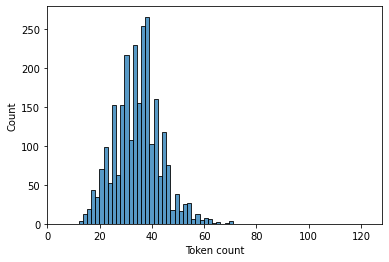

In [ ]:
sns.histplot(token_lens)
plt.xlim([0, 128]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = np.max(token_lens)
BATCH_SIZE = 32

In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
data = next(iter(val_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
n_classes = 3
class_names = ['postive', 'negative', 'neutral']

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 71])
torch.Size([32, 71])


In [ ]:
model = SentimentClassifier(n_classes)
model = model.to(device)

In [ ]:
EPOCHS = 30

optimizer = optim.AdamW(model.parameters(), lr=1e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = transformers.get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0
early_stop = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc
    early_stop = 0
  else:
      early_stop = early_stop + 1
      if early_stop == 5:
        break

Epoch 1/30
----------
Train loss 1.0363396188107932 accuracy 0.48436308161708624
Val   loss 0.9765233874320984 accuracy 0.5205479452054794

Epoch 2/30
----------
Train loss 0.8843016951549344 accuracy 0.5999237223493517
Val   loss 0.8526095449924469 accuracy 0.6027397260273972

Epoch 3/30
----------
Train loss 0.6752310391606354 accuracy 0.7337909992372236
Val   loss 0.8085805803537369 accuracy 0.6301369863013698

Epoch 4/30
----------
Train loss 0.4854252312968417 accuracy 0.8199847444698704
Val   loss 0.8220203638076782 accuracy 0.6712328767123288

Epoch 5/30
----------
Train loss 0.338317528548764 accuracy 0.8867276887871854
Val   loss 0.8434690743684768 accuracy 0.6678082191780822

Epoch 6/30
----------
Train loss 0.2720213294392679 accuracy 0.9088482074752098
Val   loss 0.8524957150220871 accuracy 0.6506849315068493

Epoch 7/30
----------
Train loss 0.1802873897661523 accuracy 0.9450800915331808
Val   loss 1.00500745177269 accuracy 0.6541095890410958

Epoch 8/30
----------
Train l

In [ ]:

model.load_state_dict(torch.load('best_model_state.bin'))

<All keys matched successfully>

In [ ]:
df_sem16test

,ID,Target,Tweet,Stance,target
0,10001,Atheism,He who exalts himself shall be humbled; a...,AGAINST,0
1,10002,Atheism,RT @prayerbullets: I remove Nehushtan -previou...,AGAINST,0
2,10003,Atheism,@Brainman365 @heidtjj @BenjaminLives I have so...,AGAINST,0
3,10004,Atheism,#God is utterly powerless without Human interv...,AGAINST,0
4,10005,Atheism,@David_Cameron Miracles of #Multiculturalism...,AGAINST,0
...,...,...,...,...,...
1244,11245,Legalization of Abortion,@MetalheadMonty @tom_six I followed him before...,NONE,1
1245,11246,Legalization of Abortion,"For he who avenges blood remembers, he does no...",AGAINST,0
1246,11247,Legalization of Abortion,Life is sacred on all levels. Abortion does no...,AGAINST,0
1247,11248,Legalization of Abortion,"@ravensymone U refer to ""WE"" which =""YOU"" & a ...",AGAINST,0


In [ ]:
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.6901521216973578

In [ ]:
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

     postive       0.78      0.75      0.76       715
    negative       0.54      0.63      0.58       230
     neutral       0.63      0.60      0.61       304

    accuracy                           0.69      1249
   macro avg       0.65      0.66      0.65      1249
weighted avg       0.70      0.69      0.69      1249



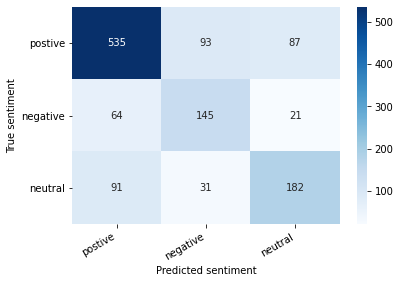

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
accuracy_score(y_test, y_pred)

0.6901521216973578

In [ ]:
f1_score(y_test, y_pred, average='weighted')

0.6921348838371798

In [ ]:
writeResultsInFile(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted'), random_seed=RANDOM_SEED)

# SemEval2020Task9

In [ ]:
%cd "/content/drive/MyDrive/TER BERTTweet/SemEval2020Task9"

/content/drive/.shortcut-targets-by-id/17CE24Rj2KkFXfKV0IKGKdgQ9DW8PLJeH/TER BERTTweet/SemEval2020Task9


In [ ]:
!ls

best_model_state.bin			 Roberta_best_model_state.bin
dev_3k_split_conll.txt			 Spanglish
FinalTest.tsv.txt			 test_labels_hinglish.txt
Hindi_test_unalbelled_conll_updated.txt  train_14k_split_conll.txt
Hinglish				 TrainV1.tsv.txt
log					 Ty.txt
log_roberta				 ValidationV1.tsv.txt


In [ ]:
 df_train = pd.read_csv("TrainV1.tsv.txt", sep="\t", header=None,  names=['id', 'body', 'target'])
df_val = pd.read_csv("ValidationV1.tsv.txt", sep="\t", header=None,  names=['id', 'body', 'target'])
df_test = pd.read_csv("FinalTest.tsv.txt", sep="\t", header=None,  names=['id', 'body'])
df_ytest = pd.read_csv("test_labels_hinglish.txt", sep=",", header=0, names=['id', 'sentiment'])

In [ ]:
df_train = df_val.append(df_train)

In [ ]:
df_test = df_test.merge(df_ytest)

In [ ]:
df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=RANDOM_SEED)

In [ ]:
df_train = df_train.dropna()

In [ ]:
df_train['target'].unique()

array([1, 0, 2])

In [ ]:
token_lens = []
for txt in df_train.body:
  tokens = tokenizer.encode(txt, max_length=128)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


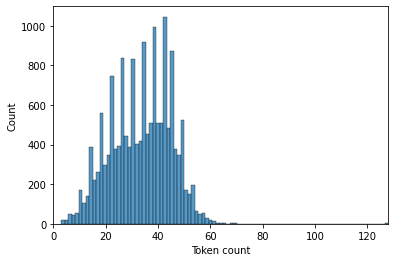

In [ ]:
sns.histplot(token_lens)
plt.xlim([0, 128]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = np.max(token_lens)
BATCH_SIZE = 32

In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
data = next(iter(val_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
n_classes = 3
class_names = ['postive', 'neutral', 'negative']

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 128])
torch.Size([32, 128])


In [ ]:
model = SentimentClassifier(n_classes)
model = model.to(device)

In [ ]:
EPOCHS = 30

optimizer = optim.AdamW(model.parameters(), lr=1e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = transformers.get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0
early_stop = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc
    early_stop = 0
  else:
      early_stop = early_stop + 1
      if early_stop == 5:
        break

Epoch 1/30
----------
Train loss 0.9231095265860509 accuracy 0.5401986210386488
Val   loss 0.9059449856931513 accuracy 0.5863636363636363

Epoch 2/30
----------
Train loss 0.7751603605169238 accuracy 0.6448858245303308
Val   loss 0.8739763162352822 accuracy 0.6130681818181818

Epoch 3/30
----------
Train loss 0.6672345910710518 accuracy 0.7141501676260358
Val   loss 0.9288547819310968 accuracy 0.6232954545454545

Epoch 4/30
----------
Train loss 0.5506914023460463 accuracy 0.7789233980643936
Val   loss 1.0126571124250239 accuracy 0.6318181818181818

Epoch 5/30
----------
Train loss 0.4455909148724091 accuracy 0.8269340249225124
Val   loss 1.005760955810547 accuracy 0.6505681818181818

Epoch 6/30
----------
Train loss 0.3732110239245524 accuracy 0.8595736605730913
Val   loss 1.0604927854104476 accuracy 0.6670454545454545

Epoch 7/30
----------
Train loss 0.3072069619189609 accuracy 0.8878486937820228
Val   loss 1.0818747011097996 accuracy 0.6749999999999999

Epoch 8/30
----------
Train 

KeyboardInterrupt: ignored

In [ ]:

model.load_state_dict(torch.load('best_model_state.bin'))

<All keys matched successfully>

In [ ]:
def sentiment_encode(sentiment):
  if sentiment == 'negative':
    return 0
  elif sentiment == 'neutral':
    return 1
  else: 
    return 2

In [ ]:
df_test['target'] = df_test.sentiment.apply(sentiment_encode)

In [ ]:
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.6403333333333333

In [ ]:
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

     postive       0.67      0.66      0.66       900
     neutral       0.54      0.60      0.57      1100
    negative       0.75      0.66      0.70      1000

    accuracy                           0.64      3000
   macro avg       0.65      0.64      0.65      3000
weighted avg       0.65      0.64      0.64      3000



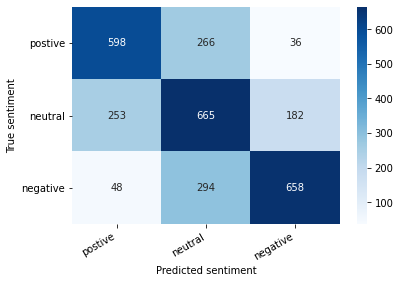

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
accuracy_score(y_test, y_pred)

0.6403333333333333

In [ ]:
f1_score(y_test, y_pred, average='weighted')

0.6430240853447026

In [ ]:
writeResultsInFile(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted'), random_seed=RANDOM_SEED)

# SemEval 2019 task 6


In [ ]:
%cd /content/drive/MyDrive/TER BERTTweet/SemEval2019Task6

/content/drive/.shortcut-targets-by-id/17CE24Rj2KkFXfKV0IKGKdgQ9DW8PLJeH/TER BERTTweet/SemEval2019Task6


In [ ]:
!ls

best_model_state.bin  log_roberta		    testset-levela.tsv
labels-levela.csv     olid-annotation.txt	    testset-levelb.tsv
labels-levelb.csv     olid-training-v1.0.tsv	    testset-levelc.tsv
labels-levelc.csv     README.txt
log		      Roberta_best_model_state.bin


In [ ]:
df_train = pd.read_csv("olid-training-v1.0.tsv", sep="\t", header=0,  names=['id', 'body', 'target', 'dropme', 'dropme2'])
df_test = pd.read_csv("testset-levela.tsv", sep="\t", header=0,  names=['id', 'body'])
df_ytest = pd.read_csv("labels-levela.csv", sep=",", header=0, names=['id', 'sentiment'])

In [ ]:
df_test = df_test.merge(df_ytest)

In [ ]:
df_train

,id,body,target,dropme,dropme2
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN
...,...,...,...,...,...
13235,95338,@USER Sometimes I get strong vibes from people...,OFF,TIN,IND
13236,67210,Benidorm ✅ Creamfields ✅ Maga ✅ Not too sh...,NOT,NaN,NaN
13237,82921,@USER And why report this garbage. We don't g...,OFF,TIN,OTH
13238,27429,@USER Pussy,OFF,UNT,NaN


In [ ]:
df_test

,id,body,sentiment
0,27014,"#ConstitutionDay is revered by Conservatives, ...",NOT
1,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,NOT
2,13876,#Watching #Boomer getting the news that she is...,NOT
3,60133,#NoPasaran: Unity demo to oppose the far-right...,OFF
4,83681,. . . What the fuck did he do this time?,OFF
...,...,...,...
854,73439,#DespicableDems lie again about rifles. Dem Di...,OFF
855,25657,#MeetTheSpeakers 🙌 @USER will present in our e...,NOT
856,67018,3 people just unfollowed me for talking about ...,OFF
857,50665,#WednesdayWisdom Antifa calls the right fascis...,NOT


In [ ]:
df_train['target'].unique()

array(['OFF', 'NOT'], dtype=object)

In [ ]:
def sentiment_encode(sentiment):
  if sentiment == 'OFF':
    return 0
  elif sentiment == 'NOT':
    return 1

In [ ]:
df_train['target'] = df_train.target.apply(sentiment_encode)

In [ ]:
df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=RANDOM_SEED)

In [ ]:
token_lens = []
for txt in df_train.body:
  tokens = tokenizer.encode(txt, max_length=128)
  token_lens.append(len(tokens))

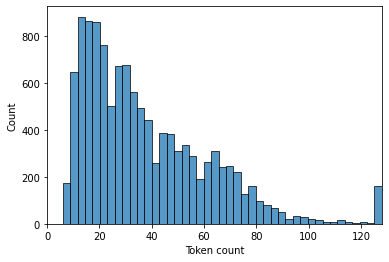

In [ ]:
sns.histplot(token_lens)
plt.xlim([0, 128]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = np.max(token_lens)
BATCH_SIZE = 32

In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
data = next(iter(val_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
n_classes = 2
class_names = ['offensive', 'not_offensive']

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 128])
torch.Size([32, 128])


In [ ]:
model = SentimentClassifier(n_classes)
model = model.to(device)

In [ ]:
EPOCHS = 30

optimizer = optim.AdamW(model.parameters(), lr=1e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = transformers.get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0
early_stop = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc
    early_stop = 0
  else:
      early_stop = early_stop + 1
      if early_stop == 5:
        break

Epoch 1/30
----------
Train loss 0.4859059655953988 accuracy 0.7682108089963074
Val   loss 0.44074404594444094 accuracy 0.7915407854984894

Epoch 2/30
----------
Train loss 0.37671474487228623 accuracy 0.8350956696878147
Val   loss 0.4713850961554618 accuracy 0.7930513595166163

Epoch 3/30
----------
Train loss 0.29138062594723124 accuracy 0.8815038603558241
Val   loss 0.5423172932295572 accuracy 0.7802114803625377

Epoch 4/30
----------
Train loss 0.20539491202921953 accuracy 0.9228768042967439
Val   loss 0.7404387820334661 accuracy 0.7749244712990937

Epoch 5/30
----------
Train loss 0.15756991686394323 accuracy 0.9435213158778113
Val   loss 0.7595460024617967 accuracy 0.7802114803625377

Epoch 6/30
----------
Train loss 0.12117123000084075 accuracy 0.957284323598523
Val   loss 0.7525060581309455 accuracy 0.7817220543806647

Epoch 7/30
----------
Train loss 0.08831077348815412 accuracy 0.9708794897616649
Val   loss 0.8550950643562135 accuracy 0.790785498489426

CPU times: user 18min 

In [ ]:

model.load_state_dict(torch.load('best_model_state.bin'))

<All keys matched successfully>

In [ ]:
df_test['target'] = df_test.sentiment.apply(sentiment_encode)

In [ ]:
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8311990686845169

In [ ]:
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

               precision    recall  f1-score   support

    offensive       0.69      0.72      0.70       239
not_offensive       0.89      0.88      0.88       620

     accuracy                           0.83       859
    macro avg       0.79      0.80      0.79       859
 weighted avg       0.83      0.83      0.83       859



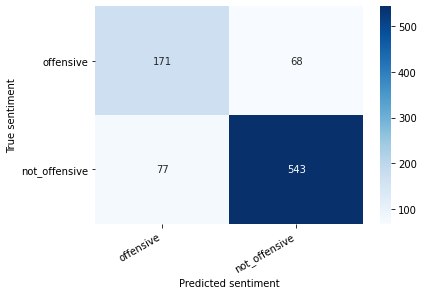

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
accuracy_score(y_test, y_pred)

0.8311990686845169

In [ ]:
f1_score(y_test, y_pred, average='weighted')

0.8321417681776657

In [ ]:
writeResultsInFile(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted'), random_seed=RANDOM_SEED)

# SemEval2017


In [ ]:
%cd '/content/drive/My Drive/TER BERTTweet/SemEval-2017Task4A/Subtask_A'

/content/drive/My Drive/TER BERTTweet/SemEval-2017Task4A/Subtask_A


In [ ]:
df = pd.read_csv('semEvaltaskA_train.txt', sep = ',')

In [ ]:
df_test = pd.DataFrame(columns=['id', 'sentiment', 'body'])
import glob
try:
    for file in glob.glob("SemEval2017-task4-test.subtask-A.english.txt"):
        data = pd.DataFrame(columns=['id', 'sentiment', 'body'])
        for line_id, line in enumerate(open(file, "r", encoding="utf-8").readlines()):
            columns = line.rstrip().split('\t')

            tweet_id = columns[0]
            sentiment = columns[1]
            text = columns[2]
            data = data.append({'id': tweet_id, 'sentiment': sentiment, 'body': text}, ignore_index=True) 
        print(f'{file} ------- {len(data)}')
        df_test = df_test.append(data, ignore_index=True)
except Exception as e:
    print("\nWrong format in line:{} in file:{}".format(line_id, file))
    raise Exception

SemEval2017-task4-test.subtask-A.english.txt ------- 12284


In [ ]:
df_train, df_val = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)

In [ ]:
def sentiment_encode(sentiment):
  if sentiment == 'negative':
    return 0
  elif sentiment == 'neutral':
    return 1
  else: 
    return 2

In [ ]:
df_train['target'] = df_train.sentiment.apply(sentiment_encode)
df_val['target'] = df_val.sentiment.apply(sentiment_encode)
df_test['target'] = df_test.sentiment.apply(sentiment_encode)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_test['target'] = df_test.sentiment.apply(sentiment_encode)

In [ ]:
class_names = ['negative', 'neutral', 'positive']

In [ ]:
 df_train.head()

,id,sentiment,body,target
18756,264229908493000704,negative,Morning all! Waking up at 1.30 to gamble may n...,0
2834,641318732829167616,neutral,Iran deal: Obama may have support he needs to ...,1
1471,636897294600810496,positive,"12 years ago today, this guy asked me to be hi...",2
44223,640823298532753408,neutral,#SW5 Yoga for Running is on this Thursday 6-8p...,1
22206,100637319375224832,neutral,He smokes weed RT @TakeF_Light :O RT @ravensbu...,1


In [ ]:
df_test.head()

,id,sentiment,body,target
0,801989080477154944,neutral,#ArianaGrande Ari By Ariana Grande 80% Full ht...,1
1,801989272341453952,positive,Ariana Grande KIIS FM Yours Truly CD listening...,2
2,801990978424962944,positive,Ariana Grande White House Easter Egg Roll in W...,2
3,801996232553963008,positive,#CD #Musics Ariana Grande Sweet Like Candy 3.4...,2
4,801998343442407040,neutral,SIDE TO SIDE 😘 @arianagrande #sidetoside #aria...,1


In [ ]:
df_val.head()

,id,sentiment,body,target
34832,631296619825119232,positive,@Michael5SOS come see Sam smith with @tragical...,2
28499,521637026743857152,neutral,"""As he won't be taking part in the #USAGP qual...",1
256,637719681298731008,neutral,See they should have announced Sting's appeara...,1
27760,519359389161897984,positive,Alright Godzilla then X-Men then Equalizer. Il...,2
49281,679307212750200832,negative,Iran Says New U.S. Visa Rule May Violate Nucle...,0


In [ ]:
BATCH_SIZE = 32

In [ ]:
MAX_LEN = 104

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((45300, 4), (5034, 4), (12284, 4))

In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 104])
torch.Size([32, 104])


In [ ]:
EPOCHS = 30

optimizer = optim.AdamW(model.parameters(), lr=1e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = transformers.get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0
early_stop = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc
    early_stop = 0
  else:
      early_stop = early_stop + 1
      if early_stop == 5:
        break

Epoch 1/30
----------
Train loss 0.6889326388258382 accuracy 0.6846136865342163
Val   loss 0.6434987660827516 accuracy 0.7081843464441796

Epoch 2/30
----------
Train loss 0.5369454999112309 accuracy 0.7651434878587197
Val   loss 0.6487921117981778 accuracy 0.7195073500198649

Epoch 3/30
----------
Train loss 0.4153733968071766 accuracy 0.8284547461368653
Val   loss 0.7295679167101655 accuracy 0.7214938418752483

Epoch 4/30
----------
Train loss 0.29747084332472185 accuracy 0.8847682119205298
Val   loss 0.8217743846434581 accuracy 0.72129519268971

Epoch 5/30
----------
Train loss 0.21032054344518372 accuracy 0.9207284768211921
Val   loss 0.9106530788578565 accuracy 0.72367898291617

Epoch 6/30
----------
Train loss 0.16608479563317835 accuracy 0.9401103752759382
Val   loss 1.0174371109733098 accuracy 0.7226857369884784

Epoch 7/30
----------
Train loss 0.128055916424304 accuracy 0.9552980132450332
Val   loss 1.0890543728689603 accuracy 0.7123559793404847

Epoch 8/30
----------
Train l

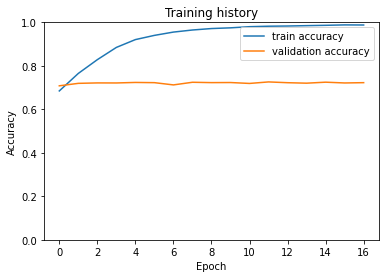

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);


In [ ]:
history

defaultdict(list,
            {'train_acc': [tensor(0.6846, device='cuda:0', dtype=torch.float64),
              tensor(0.7651, device='cuda:0', dtype=torch.float64),
              tensor(0.8285, device='cuda:0', dtype=torch.float64),
              tensor(0.8848, device='cuda:0', dtype=torch.float64),
              tensor(0.9207, device='cuda:0', dtype=torch.float64),
              tensor(0.9401, device='cuda:0', dtype=torch.float64),
              tensor(0.9553, device='cuda:0', dtype=torch.float64),
              tensor(0.9649, device='cuda:0', dtype=torch.float64),
              tensor(0.9715, device='cuda:0', dtype=torch.float64),
              tensor(0.9748, device='cuda:0', dtype=torch.float64),
              tensor(0.9801, device='cuda:0', dtype=torch.float64),
              tensor(0.9823, device='cuda:0', dtype=torch.float64),
              tensor(0.9832, device='cuda:0', dtype=torch.float64),
              tensor(0.9849, device='cuda:0', dtype=torch.float64),
              ten

In [ ]:
model.load_state_dict(torch.load('best_model_state.bin'))

<All keys matched successfully>

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.6733148811462065

In [ ]:
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.70      0.64      0.67      3972
     neutral       0.67      0.70      0.69      5937
    positive       0.64      0.67      0.65      2375

    accuracy                           0.67     12284
   macro avg       0.67      0.67      0.67     12284
weighted avg       0.67      0.67      0.67     12284



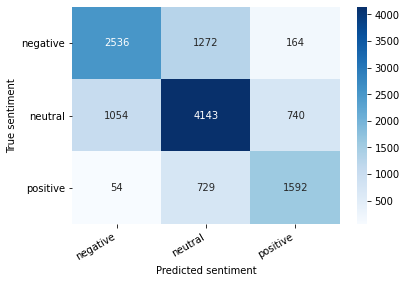

In [ ]:

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
f1_score(y_test, y_pred, average='weighted')

0.6732077660857182

In [ ]:
f1_score(y_test, y_pred, average=None)

array([0.66596639, 0.68587037, 0.65366455])

In [ ]:
recall_score(y_test, y_pred, average = None)

array([0.63846928, 0.69782719, 0.67031579])

In [ ]:
precision_score(y_test, y_pred, average = None)

array([0.69593853, 0.67431641, 0.63782051])

In [ ]:
writeResultsInFile(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted'), random_seed=RANDOM_SEED)

#SemEval 2020 Task 12

In [ ]:
%cd /content/drive/MyDrive/TER BERTTweet/SemEval2020Task12

/content/drive/MyDrive/TER BERTTweet/SemEval2020Task12


In [ ]:
!ls

task_a_distant.tsv	test_b_labels_all.csv	test_c_labels.csv
test_a_labels_all.csv	test_b_labels.csv	test_c_labels_easy.csv
test_a_labels.csv	test_b_labels_easy.csv	test_c_labels_hard.csv
test_a_labels_easy.csv	test_b_labels_hard.csv	test_c_tweets_all.tsv
test_a_labels_hard.csv	test_b_tweets_all.tsv	test_c_tweets.tsv
test_a_tweets_all.tsv	test_b_tweets.tsv
test_a_tweets.tsv	test_c_labels_all.csv


In [ ]:
df_train = pd.read_csv("task_a_distant.tsv", sep="\t", header=0,  names=['id', 'body', 'target'])
df_test = pd.read_csv("test_a_tweets_all.tsv", sep="\t", header=0,  names=['id', 'body'])
df_ytest = pd.read_csv("test_a_labels_all.csv", sep=",", header=0, names=['id', 'sentiment'])

In [ ]:
df_test = df_test.merge(df_ytest)

In [ ]:
df_train

,id,body,target
0,1159533701283352576,0.195773,0.187379
1,1159533703522992128,0.262401,0.145998
2,1159533703758061570,0.833391,0.140628
3,1159533703904800769,0.565238,0.187498
4,1159533705125343232,0.664921,0.097098
...,...,...,...
9089135,1187517463640137728,0.174259,0.205074
9089136,1187636341338710016,0.487383,0.067990
9089137,1187636341560889344,0.241537,0.176056
9089138,1187636341661679617,0.251834,0.170168


In [ ]:
df_test

,id,body,sentiment
0,B0,Has @USER quit? I've not heard of any #knifecr...,NOT
1,B1,"In celebration of Emancipation Day, we urge yo...",NOT
2,B2,@USER @USER It’d be a literal dream come true ...,NOT
3,B3,Brilliant news to read that Hoggy has signed a...,NOT
4,B4,@USER She speaks of the truth 😌,NOT
...,...,...,...
5987,BC2101,@USER @USER Nothing about trump is human or no...,OFF
5988,BC2102,@USER Oh shit. That sounds like a cool time tho,OFF
5989,BC2103,@USER @USER I gotta say that shit to you one t...,OFF
5990,BC2104,@USER tRUmp does everything he can to destroy ...,OFF


In [ ]:
df_train['target'].unique()

array([0.18737871, 0.14599806, 0.14062767, ..., 0.17605566, 0.17016828,
       0.19650852])

In [ ]:
def sentiment_encode(sentiment):
  if sentiment == 'OFF':
    return 0
  elif sentiment == 'NOT':
    return 1

In [ ]:
df_train['target'] = df_train.target.apply(sentiment_encode)

In [ ]:
df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=RANDOM_SEED)

In [ ]:
token_lens = []
for txt in df_train.body:
  tokens = tokenizer.encode(txt, max_length=128)
  token_lens.append(len(tokens))

ValueError: ignored

In [ ]:
sns.histplot(token_lens)
plt.xlim([0, 128]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = np.max(token_lens)
BATCH_SIZE = 32

In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

In [ ]:
data = next(iter(val_data_loader))
data.keys()

In [ ]:
n_classes = 2
class_names = ['offensive', 'not_offensive']

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

In [ ]:
model = SentimentClassifier(n_classes)
model = model.to(device)

In [ ]:
EPOCHS = 30

optimizer = optim.AdamW(model.parameters(), lr=1e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = transformers.get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0
early_stop = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc
    early_stop = 0
  else:
      early_stop = early_stop + 1
      if early_stop == 5:
        break

In [ ]:

model.load_state_dict(torch.load('best_model_state.bin'))

In [ ]:
df_test['target'] = df_test.sentiment.apply(sentiment_encode)

In [ ]:
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

In [ ]:
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
f1_score(y_test, y_pred, average='weighted')

In [ ]:
writeResultsInFile(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted'), random_seed=RANDOM_SEED)